# 숙소 리뷰 요약을 위한 LLM 모델 만들기
- 호텔 리뷰를 요약하는 모델을 만들고 성능을 향상시키기

### 1. API 키 및 기본 설정

In [1]:
from openai import OpenAI
from getpass import getpass

In [2]:
MY_API_KEY = getpass("OpenAI API Key >> ")

In [3]:
client = OpenAI(api_key = MY_API_KEY)

### 2. 데이터 전처리
- 모델 평가를 위한 프롬프트에 입력하기 위해 기존 JSON 형태에서 문자열로 
#### 1) 수집한 리뷰 JSON 파일 로드
- 야놀자 홈페이지 호텔/리조트 탭에서 신라스테이 역삼 호텔에 대한 리뷰를 최근 순으로 20 스크롤 정도 조회한 데이터

In [4]:
import json

In [5]:
with open("../data/ya_review_sinla.json", "r", encoding = "utf-8") as f :
    # json.load() : JSON 데이터 불러오기
    review_lst = json.load(f)

print(len(review_lst))
review_lst[:10]

420


[{'review': '출장때마다 신라스테이를 이용하고 있습니다.\n너무 비싼데는 회사 지원이 어려워서 신라스테이를 이용하는데, 깔끔하고 친절하고..이만한데가 없네요',
  'stars': 5,
  'date': '4일 전'},
 {'review': '깔끔하고 청결합니다', 'stars': 5, 'date': '4일 전'},
 {'review': '지하철로 오는거면 위치가 좀 별로긴 한데 시내에 있어서 나쁘지 않아요. 직원분들 친절하고 가격도 착해서 좋습니다.\n주말 저녁, 조식 다 이용해봤는데 쏘쏘합니다',
  'stars': 5,
  'date': '5일 전'},
 {'review': '조앗ㄹ어여!!굳굳굳', 'stars': 5, 'date': '6일 전'},
 {'review': '너무 좋아요. 에어컨이 좀 약해요', 'stars': 5, 'date': '6일 전'},
 {'review': '출장 시 자주이용합니다. 쾌적하게 잘 쉬다 왔네요^^', 'stars': 4, 'date': '2024.06.20'},
 {'review': '친절하고 깨끗하고 주차도 편해요', 'stars': 5, 'date': '2024.06.15'},
 {'review': '가격만큼 하는 곳 교통이 아쉬워여 ㅠ', 'stars': 5, 'date': '2024.06.12'},
 {'review': '편하긴 햇러요 청결하고, 조식 맛잇엇습니디', 'stars': 4, 'date': '2024.06.09'},
 {'review': '좋은데 방음은 조금 어쩔수 없엇요아늑하고 좋앗어요.', 'stars': 4, 'date': '2024.06.09'}]

#### 2) 높은 평점 및 낮은 평점 기준 정의
전체 평점이 4.7점이기 때문에 대부분의 평점은 4 ~ 5점 사이이고, 정말 별로이지 않는 한 3점 이하는 잘 없는 데이터 분포
- 높은 평점 : 별 5개
- 낮은 평점 : 별 4개 이하

In [6]:
import numpy as np
import seaborn as sns

In [7]:
tmp_lst = [i["stars"] for i in review_lst]
np.mean(tmp_lst)

4.697619047619048

<Axes: ylabel='count'>

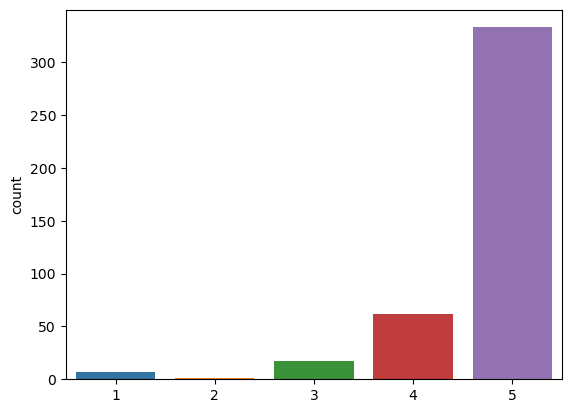

In [8]:
tmp_arr = np.array(tmp_lst)
sns.countplot(x = tmp_arr)

#### 3) 높은 평점 및 낮은 평점으로 구분 후 저장

In [10]:
review_high, review_low = [], []
for i in review_lst :
    if i["stars"] == 5 :
        review_high.append("[REVIEW_START]" + i["review"] + "[REVIEW_END]")
    else :
        review_low.append("[REVIEW_START]" + i["review"] + "[REVIEW_END]")

print(review_high[:5])

['[REVIEW_START]출장때마다 신라스테이를 이용하고 있습니다.\n너무 비싼데는 회사 지원이 어려워서 신라스테이를 이용하는데, 깔끔하고 친절하고..이만한데가 없네요[REVIEW_END]', '[REVIEW_START]깔끔하고 청결합니다[REVIEW_END]', '[REVIEW_START]지하철로 오는거면 위치가 좀 별로긴 한데 시내에 있어서 나쁘지 않아요. 직원분들 친절하고 가격도 착해서 좋습니다.\n주말 저녁, 조식 다 이용해봤는데 쏘쏘합니다[REVIEW_END]', '[REVIEW_START]조앗ㄹ어여!!굳굳굳[REVIEW_END]', '[REVIEW_START]너무 좋아요. 에어컨이 좀 약해요[REVIEW_END]']


In [12]:
# LLM 모델에 입력되는 프롬프트 작성 시, 문자열 이어야 하므오 리스트에 있는 리뷰를 문자열로 통합하고 개행으로 각 리뷰들을 구분
review_high_txt = "\n".join(review_high)
review_low_txt = "\n".join(review_low)

print(review_high_txt[:500])

[REVIEW_START]출장때마다 신라스테이를 이용하고 있습니다.
너무 비싼데는 회사 지원이 어려워서 신라스테이를 이용하는데, 깔끔하고 친절하고..이만한데가 없네요[REVIEW_END]
[REVIEW_START]깔끔하고 청결합니다[REVIEW_END]
[REVIEW_START]지하철로 오는거면 위치가 좀 별로긴 한데 시내에 있어서 나쁘지 않아요. 직원분들 친절하고 가격도 착해서 좋습니다.
주말 저녁, 조식 다 이용해봤는데 쏘쏘합니다[REVIEW_END]
[REVIEW_START]조앗ㄹ어여!!굳굳굳[REVIEW_END]
[REVIEW_START]너무 좋아요. 에어컨이 좀 약해요[REVIEW_END]
[REVIEW_START]친절하고 깨끗하고 주차도 편해요[REVIEW_END]
[REVIEW_START]가격만큼 하는 곳 교통이 아쉬워여 ㅠ[REVIEW_END]
[REVIEW_START]고민하다가 조식포함으로 결정했는데 좋은 선택이었습니다. 같이간 이들도 만족스러워했어요. 조식도 좋았고


#### 4) 각 전처리 단계를 하나의 사용자 정의 함수로 작성
- 야놀자 홈페이지의 후기 요약도 최근 6개월 간의 리뷰로 진행했기 때문에 동일한 조건으로 설정

In [13]:
# 날짜와 시간을 다루는 모듈
import datetime
# 날짜와 시간 문자열을 파싱해서 실제 날짜 계산이 가능한 기능을 지원하는 라이브러리
# parser : 문자열에서 날짜와 시간 정보를 자동으로 인식하고 파싱하는 모듈
from dateutil import parser

In [14]:
datetime.datetime.now()

datetime.datetime(2024, 7, 10, 2, 24, 3, 806048)

In [23]:
# 리뷰 전처리 사용자 정의 함수 선언
def preprocess_reviews(path = "../data/ya_review_sinla.json") :
    with open(path, "r", encoding = "utf-8") as f :
        review_list = json.load(f)
        
    review_high, review_low = [], []
    current_date = datetime.datetime.now()
    # timedelta : 파라미터 weeks, days, hours, minutes, seconds 등
    date_boundary = current_date - datetime.timedelta(days = 6 * 30) # 6개월 전
    
    for i in review_list :
        review_date_str = i["date"]
        try :
            # parse() : 리뷰에 대한 연/월/일/시 문자열이 들어오면 날짜 타입으로 변환
            review_date = parser.parse(review_date_str)
        except (ValueError, TypeError) : # 연/월/일로 표시되지 않은 값들
            review_date = current_date # 현재 날짜로 지정
            
        if review_date < date_boundary : # 6개월 이전의 데이터
            continue # 다음 for문으로 가시오
            
        if i["stars"] == 5 :
            review_high.append("[REVIEW_START]" + i["review"] + "[REVIEW_END]")
        else :
            review_low.append("[REVIEW_START]" + i["review"] + "[REVIEW_END]")
    
    # 전처리가 완료된 평점들의 전체 문자열 데이터
    review_high_txt = "\n".join(review_high)
    review_low_txt = "\n".join(review_low)
    
    return review_high_txt, review_low_txt

In [24]:
high, low = preprocess_reviews()
high[:500]

'[REVIEW_START]출장때마다 신라스테이를 이용하고 있습니다.\n너무 비싼데는 회사 지원이 어려워서 신라스테이를 이용하는데, 깔끔하고 친절하고..이만한데가 없네요[REVIEW_END]\n[REVIEW_START]깔끔하고 청결합니다[REVIEW_END]\n[REVIEW_START]지하철로 오는거면 위치가 좀 별로긴 한데 시내에 있어서 나쁘지 않아요. 직원분들 친절하고 가격도 착해서 좋습니다.\n주말 저녁, 조식 다 이용해봤는데 쏘쏘합니다[REVIEW_END]\n[REVIEW_START]조앗ㄹ어여!!굳굳굳[REVIEW_END]\n[REVIEW_START]너무 좋아요. 에어컨이 좀 약해요[REVIEW_END]\n[REVIEW_START]친절하고 깨끗하고 주차도 편해요[REVIEW_END]\n[REVIEW_START]가격만큼 하는 곳 교통이 아쉬워여 ㅠ[REVIEW_END]\n[REVIEW_START]고민하다가 조식포함으로 결정했는데 좋은 선택이었습니다. 같이간 이들도 만족스러워했어요. 조식도 좋았고'

### 3. 리뷰 요약을 위한 Base 모델 개발
- Base 모델(gpt-3.5-turbo)이 야놀자 후기 요약 문장(gpt-4-turbo 사용)에 근접하게 요약할 수 있도록 성능을 향상하는 것이 목표

In [25]:
# 요약 Task에서는 요약 결과에 대한 길이나 제한을 두는 것이 품질을 평가히기 좋음 (언급이 없으면 모델의 max 토큰까지 출력해 버리는 현상 발생)
PROMPT_BASELINE = """아래 숙소 리뷰에 대해 5문장 내로 요약해줘"""

In [26]:
# 전처리 함수를 사용하여 높은 평점 리뷰만 가져오기
# high만 받고 low 안받음
reviews, _ = preprocess_reviews("../data/ya_review_sinla.json")
reviews

'[REVIEW_START]출장때마다 신라스테이를 이용하고 있습니다.\n너무 비싼데는 회사 지원이 어려워서 신라스테이를 이용하는데, 깔끔하고 친절하고..이만한데가 없네요[REVIEW_END]\n[REVIEW_START]깔끔하고 청결합니다[REVIEW_END]\n[REVIEW_START]지하철로 오는거면 위치가 좀 별로긴 한데 시내에 있어서 나쁘지 않아요. 직원분들 친절하고 가격도 착해서 좋습니다.\n주말 저녁, 조식 다 이용해봤는데 쏘쏘합니다[REVIEW_END]\n[REVIEW_START]조앗ㄹ어여!!굳굳굳[REVIEW_END]\n[REVIEW_START]너무 좋아요. 에어컨이 좀 약해요[REVIEW_END]\n[REVIEW_START]친절하고 깨끗하고 주차도 편해요[REVIEW_END]\n[REVIEW_START]가격만큼 하는 곳 교통이 아쉬워여 ㅠ[REVIEW_END]\n[REVIEW_START]고민하다가 조식포함으로 결정했는데 좋은 선택이었습니다. 같이간 이들도 만족스러워했어요. 조식도 좋았고 시설, 서비스, 청결도 나무랄데가 없었네요.[REVIEW_END]\n[REVIEW_START]쾌적하고 좋은 환경에서 잘 쉬고 갑니다![REVIEW_END]\n[REVIEW_START]깔끔하고좋았어요 ㅎㅎ[REVIEW_END]\n[REVIEW_START]깨끗하고 위치도 좋으며 주차장이 기께식이 아닌 게 마음에 듭니다. 주차 요금이 5000원 나오긴 하지만 넓은 주차장이 좋습니다. 다음에도 이용하고 싶습니다.[REVIEW_END]\n[REVIEW_START]감사합니다. 감사합니다.[REVIEW_END]\n[REVIEW_START]직원들이 친절하고 룸상태가\n좋았습니다[REVIEW_END]\n[REVIEW_START]깨끗합니다~~~~~~~~~[REVIEW_END]\n[REVIEW_START]침대가 조금 작았어요[REVIEW_END]\n[REVIEW_START]교통의 요충지 강남에서 잘 쉬었습니다![REVIEW_END]\n[REVIEW_START]상당히 좋았습니다.[RE

1) 요약 실행 함수 선언

In [27]:
# LLM 모델을 호출하여 리뷰들에 대한 요약을 진행하는 사용자 정의 함수 선언
def summarize(reviews, prompt, temperature = 0, model = "gpt-3.5-turbo") :
    prompt = prompt + "\n\n" + reviews
    completion = client.chat.completions.create(
        model = model,
        messages = [{"role" : "user", "content" : prompt}],
        temperature = temperature
    )
    return completion

2) 모델 별 요약 결과

In [28]:
# Base 모델 요약 결과 (gpt-3.5-turbo)
print(summarize(reviews, PROMPT_BASELINE).choices[0].message.content)

신라스테이 출장 때마다 이용하고 있으며 깔끔하고 친절한 숙소로 만족하고 있습니다. 위치가 좋아서 시내 이동이 편리하며 주차도 편리하고 조식도 만족스러웠습니다. 에어컨이 약한 점이 있지만 친절한 직원과 깨끗한 시설로 만족스러운 숙박이었습니다.


In [32]:
# 야놀자 홈페이지 높은 평점 후기 요약 문장 (gpt-4-turbo 모델 사용)
summary_gpt4_turbo = """
깔끔하고 친절한 서비스와 청결한 객실로 출장이나 여행에 이상적인 숙소입니다.
주변 식당이 풍부하고 주차도 편리하며, 조식은 만족스러울 정도로 훌륭합니다.
다만 지하철 소음이 조금 거슬리는 점과 뷰가 아쉬운 점이 있을 수 있습니다.
전체적으로 만족도가 높고 가격 대비 좋은 숙소로 손꼽힙니다.
호텔 직원들의 친절한 응대와 편리한 시설로 쾌적한 숙박 경험을 제공받을 수 있습니다.
"""

### 4. 모델 평가 함수 선언
#### 1) 평가 기준 설정
- 논문 기반 Pairwise Comparision
  - LLM 기반 품질 비교 평가
  - gpt-4o를 활용하여 2개 모델의 요약 결과를 비교 평가
#### 2) 평가를 위한 스크립트 및 모델 실행 코드 작성
- 기존 MT-Bench.. 논문의 프롬프트에서 일부만 수정하여 사용

In [29]:
# 2개의 모델이 요약한 내용을 비교하여 평가하는 사용자 정의 함수 (리뷰 내용, 첫 모델 답변, 둘째 모델 답변)
def pairwise_eval(reviews, answer_a, answer_b) :
    # 예시 프롬프트에 gpt3.5모델과 4모델의 요약 결과를 넣고 비교하도록 프롬프트 설정
    eval_prompt = f"""
        [System]
        Please act as an impartial judge and evaluate the quality of the Korean summaries provided by two
        AI assistants to the set of user reviews on accommodations displayed below. You should choose the assistant that
        follows the user’s instructions and answers the user’s question better. Your evaluation
        should consider factors such as the helpfulness, relevance, accuracy, depth, creativity,
        and level of detail of their responses. Begin your evaluation by comparing the two
        responses and provide a short explanation. Avoid any position biases and ensure that the
        order in which the responses were presented does not influence your decision. Do not allow
        the length of the responses to influence your evaluation. Do not favor certain names of
        the assistants. Be as objective as possible. After providing your explanation, output your
        final verdict by strictly following this format: "[[A]]" if assistant A is better, "[[B]]"
        if assistant B is better, and "[[C]]" for a tie.
        [User Reviews]
        {reviews}
        [The Start of Assistant A’s Answer]
        {answer_a}
        [The End of Assistant A’s Answer]
        [The Start of Assistant B’s Answer]
        {answer_b}
        [The End of Assistant B’s Answer]
        """
    
    completion = client.chat.completions.create(
        model = "gpt-4o-2024-05-13",
        messages = [{"role" : "user", "content" : eval_prompt}],
        temperature = 0
    )
    return completion

In [30]:
# Base 모델 : gpt-3.5-turbo
answer_a = summarize(reviews, PROMPT_BASELINE).choices[0].message.content

In [35]:
# 비교 평가 함수 호출
print(pairwise_eval(reviews, answer_a, summary_gpt4_turbo).choices[0].message.content)

Both Assistant A and Assistant B provided summaries of the user reviews for the accommodations, but there are notable differences in their approaches and the details they included.

**Assistant A:**
- Focuses on the overall satisfaction with the accommodation, particularly for business trips.
- Mentions the cleanliness, friendly service, and the adequacy of the breakfast.
- Highlights the convenience of the location despite some transportation issues.
- Notes specific issues such as the weak air conditioning.

**Assistant B:**
- Emphasizes the cleanliness and friendly service, making it suitable for both business and leisure.
- Mentions the convenience of nearby restaurants and parking.
- Highlights the breakfast as satisfactory.
- Points out potential issues like subway noise and the view.
- Concludes with a general statement about the high satisfaction and good value for money.

**Comparison:**
- **Helpfulness and Relevance:** Both summaries are helpful and relevant, but Assistant B 

- 논문의 예시 스크립트를 활용하면 항상 어떤 응답이 좋은 지에 대한 의견을 확실히 볼 수 있음
- 즉, 우리가 프롬프트를 작성할 때 원하는 결과에 대해 출력 형태를 명확히 명시하면 좋은 결과를 볼 수 있음

### 5. 메인 평가 진행
- 실무에서는 다양한 데이터에 대해 많은 횟수로 평가를 하지만 현재는 그렇게 하기 힘들기 때문에 동일한 prompt에 대해서 temperature를 높여 다양한 결과를 출력 해보고 평가 횟수도 10번 정도 진행
- 보통 50 ~ 100번 정도의 평가를 진행하는 것이 좋으나, 시간과 비용 문제로 10번만 진행

In [36]:
# temperature = 0.8 설정 후, Base 모델로 10번의 요약 결과를 리스트에 담기
eval_cnt = 10
sum_baseline = [summarize(reviews, PROMPT_BASELINE, temperature = 0.8).choices[0].message.content for _ in range(eval_cnt)]
sum_baseline

['신라스테이를 출장 때마다 이용하고 있으며 깔끔하고 친절한 숙소라고 합니다. 위치가 좋고 주차도 편리하며 조식도 만족스러웠다고 합니다. 다만 에어컨은 약한 편이었다고 하네요. 깔끔하고 좋은 환경에서 편안히 쉬었다고 하며, 조식이 맛있고 룸 상태도 좋았다고 합니다. 위치가 좋고 가성비 좋은 곳이라고 하며, 주차장이 넓고 깨끗하다고 합니다.',
 '신라스테이 출장 때마다 이용하는데 깔끔하고 친절하며 좋았으며, 조식도 맛있었고 위치가 좋고 주차도 편리했습니다. 호텔은 깨끗하고 편안하며 만족스러웠습니다.',
 '신라스테이는 비싼데 깔끔하고 친절한 숙소로, 위치는 별로지만 시설과 서비스로 만족스럽다.',
 '신라스테이 숙소는 깔끔하고 친절하며, 위치와 가격도 좋은 곳으로 평가받고 있습니다.',
 '신라스테이 출장 때마다 이용하는데 친절하고 깔끔, 위치가 시내에 있어서 좋다. 주차도 편하고 조식도 괜찮은 편. 에어컨이 조금 약한 점이 아쉽다.',
 '신라스테이 출장 때마다 이용하고 있어서 좋아요. 깨끔하고 친절하며 만족스러운 숙소. 위치는 별로지만 가격과 서비스는 좋음. 조식 맛도 좋고 깔끔한 객실. 에어컨이 약한 점만 아쉬움.',
 '신라스테이 출장 이용자들에게 깔끔하고 친절한 숙소로 인기가 많으며, 조식과 주차도 편리하다. 에어컨이 약한 점과 교통이 아쉬운 점이 있지만, 전반적으로 만족스러운 숙박이다.',
 '출장 때마다 신라스테이 이용 중. 친절하고 깔끔하며 가격도 적절함. 주차 편리. 조식은 쏘쏘.',
 '출장 때마다 신라스테이 이용, 깔끔하고 친절. 지하철로 오는 건 별로지만 시내 위치는 나쁘지 않음. 주차도 편하고 조식도 만족스러움. 에어컨이 약하긴 하지만 깨끗하고 친절한 숙소.',
 '출장 때 마다 신라스테이를 이용하고 있어서 깔끔하고 친절한 숙소라 만족하고 있다. 위치는 별로지만 시내에 있어 나쁘지 않고 주차도 편리하며 조식이 쏘쏘한 편이다. 숙소는 깨끗하고 주차장이 넓어서 만족하며, 조식 포함으로 선택했을 때는 좋은 선택이었다. 에어컨이 약한 점을 제외

In [37]:
from tqdm import tqdm

In [38]:
# pairwise_eval() 함수로 평가를 10번 반복하여 Base 모델이 gpt4 모델에 비해 얼마나 승리했는지 평가하는 함수
def pairwise_eval_batch(reviews, answer_a, answer_b) :
    # 승리, 패배, 무승부 횟수
    a_cnt, b_cnt, c_cnt = 0, 0, 0
    
    for i in tqdm(range(len(answer_a))) :
        completion = pairwise_eval(reviews, answer_a[i], answer_b[i])
        # pairwise_eval() 평가 함수도 리턴 값이 gpt가 응답하는 ChatCompletion 객체로 반환하므로 해당 내용을 가져와 변수에 할당
        result_txt = completion.choices[0].message.content
        
        if "[[A]]" in result_txt :
            a_cnt += 1
        elif "[[B]]" in result_txt :
            b_cnt += 1
        elif "[[C]]" in result_txt :
            c_cnt += 1
        else :
            print("error!")
            
    return a_cnt, b_cnt, c_cnt

In [39]:
summarize_gpt4 = [summary_gpt4_turbo for _ in range(len(sum_baseline))]
wins, losses, ties = pairwise_eval_batch(reviews, sum_baseline, summarize_gpt4)
print(f"Wins : {wins}, Losses : {losses}, Ties : {ties}")

100%|██████████| 10/10 [01:01<00:00,  6.17s/it]

Wins : 1, Losses : 9, ties : 0


- BASE_PROMPT로 10번 비교 평가 시, gpt-3.5 모델의 패배가 훨씬 많음

### 모델 고도화
1) 프롬프트 엔지니어링 (명확한 조건 명시)

In [40]:
prompt = """
당신은 요약 전문가입니다. 사용자 숙소 리뷰들이 주어졌을 때 요약하는 것이 당신의 목표입니다.
요약 결과는 다음 조건들을 충족해야 합니다.
1. 모든 문장은 항상 존댓말로 끝나야 합니다.
2. 숙소에 대해 소개하는 톤앤매너로 작성해주세요.
 2-1. 좋은 리뷰 요약 예시
  a) 전반적으로 좋은 숙소였고, 방금도 괜찮았다는 평입니디.
  b) 재방문 예정이라는 평들이 존재합니다.
 2-2. 나쁜 리뷰 요약 예시
  a) 좋은 숙소였고 방금도 괜찮음
  b) 재방문 예정
3. 요약 결과는 최소 2문장, 최대 5문장 사이로 작성하세요.

아래 숙소 리뷰들에 대해 요약하세요 :
"""
eval_cnt = 10
# 변경한 프롬프트를 넣어 gpt-3.5 모델로 10번 요약 실행
summaries_opt1 = [summarize(reviews, prompt, temperature = 0.8).choices[0].message.content for _ in range(eval_cnt)]

wins, losses, ties = pairwise_eval_batch(reviews, summaries_opt1, [summary_gpt4_turbo for _ in range(len(summaries_opt1))])
print(f"Wins : {wins}, Losses : {losses}, Ties : {ties}")

100%|██████████| 10/10 [01:11<00:00,  7.13s/it]

Wins : 5, Losses : 5, Ties : 0


- 특정 case에 대해서는 프롬프트를 수정한 gpt-3.5-turbo 모델이 이긴 것을 확인할 수 있음 (약간의 성능 향상)

2) 입력 데이터의 품질 향상
- 실제 숙소에 대한 정보가 포함되지 않는 단순하고 짧은 리뷰들은 필터링 (ex. 좋았어요, 굿굿굿 등)

In [41]:
# 위의 전처리 함수를 가져와 일부 수정
def preprocess_reviews(path = "../data/ya_review_sinla.json") :
    with open(path, "r", encoding = "utf-8") as f :
        review_list = json.load(f)
        
    review_high, review_low = [], []
    current_date = datetime.datetime.now()
    date_boundary = current_date - datetime.timedelta(days = 6 * 30) # 6개월 전
    
    filtered_cnt = 0 # 일정 길이보다 짧아 필터링 된 리뷰의 개수
    
    for i in review_list :
        review_date_str = i["date"]
        try :
            review_date = parser.parse(review_date_str)
        except (ValueError, TypeError) :
            review_date = current_date
            
        if review_date < date_boundary :
            continue

        # 리뷰의 길이가 20자 미만이면 다음 for문 실행
        if len(i["review"]) < 20 :
            filtered_cnt += 1
            continue
            
        if i["stars"] == 5 :
            review_high.append("[REVIEW_START]" + i["review"] + "[REVIEW_END]")
        else :
            review_low.append("[REVIEW_START]" + i["review"] + "[REVIEW_END]")

    # min 함수를 활용하여 20자 이상인 리뷰들의 개수가 50개보다 적다면 리뷰의 갯수 만큼만 사용하고,
    # 50개 보다 더 많더라도 50개 까지로 제한(gpt3.5의 경우 토큰 수 제한으로 입력이 너무 길면 에러 발생)
    review_high = review_high[:min(len(review_high), 50)]
    review_low = review_low[:min(len(review_low), 50)]

    print("20자 미만 리뷰 개수 : ", filtered_cnt) # 20자 미만으로 필터링 된 리뷰 갯수
    print("필터링 된 높은 평점 개수 : ", len(review_high))
    
    review_high_txt = "\n".join(review_high)
    review_low_txt = "\n".join(review_low)
    
    return review_high_txt, review_low_txt

In [42]:
# 변경 된 전처리 함수 적용
reviews, _ = preprocess_reviews("../data/ya_review_sinla.json")
eval_cnt = 10

# 요약
summaries_opti2 = [summarize(reviews, prompt, temperature = 0.8).choices[0].message.content for _ in range(eval_cnt)]

# 평가
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti2, [summary_gpt4_turbo for _ in range(len(summaries_opti2))])
print(f"Wins : {wins}, Losses : {losses}, Ties : {ties}")

20자 미만 리뷰 개수 :  83
필터링 된 높은 평점 개수 :  50


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]

Wins : 9, Losses : 1, Ties : 0


- 입력 리뷰 중에서 요약에 크게 도움이 되지 않는 데이터를 줄여주는 것만으로도 큰 성능 향상을 볼 수 있음
- 다만 그만큼 입력된 데이터의 수가 적어졌기 때문에 범용적으로 좋은 요약 모델이라고 섣부르게 판단 금지 (더 다양하고 많은 양의 데이터로 테스트 필요)

3) Few-Shot learning
- 기존 gpt-3.5-turbo 모델을 활용한 요약의 성능을 추가로 올리기 위해 Few-Shot을 적용
- Few-Shot은 요청-응답 쌍의 예시를 들어줘야 하는데, 새로운 숙소 리뷰와 그 요약을 예시로 사용

In [43]:
# 요약 예시문을 위해 글래드 강남 코엑스 센터 호텔의 리뷰를 불러와 전처리 진행
reviews_1shot, _ = preprocess_reviews("../data/ya_review_glad.json")

# 요약 예시를 생성하기 위해 좀 더 좋은 모델을 사용하고, 출력도 일관되게 temperature를 0으로 지정
summary_1shot = summarize(reviews_1shot, prompt, temperature = 0, model = "gpt-4o").choices[0].message.content
summary_1shot

20자 미만 리뷰 개수 :  117
필터링 된 높은 평점 개수 :  50


'글래드 삼성점은 삼성역 바로 앞에 위치해 있어 접근성이 매우 좋다는 평이 많습니다. 객실은 깔끔하고 청결하며, 직원들의 친절한 서비스가 돋보입니다. 셀프 체크인 시스템과 다양한 편의시설이 잘 갖추어져 있어 편리하게 이용할 수 있습니다. 조식도 맛있고 알찬 구성으로 제공되며, 넷플릭스와 같은 OTT 서비스도 이용 가능합니다. 다만, 일부 고객들은 공사 소음과 주차 비용에 대해 아쉬움을 표했습니다.'

In [44]:
prompt_1shot = f"""
당신은 요약 전문가입니다. 사용자 숙소 리뷰들이 주어졌을 때 요약하는 것이 당신의 목표입니다.
요약 결과는 다음 조건들을 충족해야 합니다.
1. 모든 문장은 항상 존댓말로 끝나야 합니다.
2. 숙소에 대해 소개하는 톤앤매너로 작성해주세요.
 2-1. 좋은 리뷰 요약 예시
  a) 전반적으로 좋은 숙소였고, 방금도 괜찮았다는 평입니디.
  b) 재방문 예정이라는 평들이 존재합니다.
 2-2. 나쁜 리뷰 요약 예시
  a) 좋은 숙소였고 방금도 괜찮음
  b) 재방문 예정
3. 요약 결과는 최소 2문장, 최대 5문장 사이로 작성하세요.

다음은 리뷰들과 요약 예시입니다.

예시 리뷰들 :
{reviews_1shot}
예시 요약 결과 :
{summary_1shot}

아래 숙소 리뷰들에 대해 요약하세요 :
"""

# 요약
eval_cnt = 10

# gpt-3.5의 성능 고도화
# 4o는 3.5 모델의 성능을 높이기 위한 few-shot의 예시를 생성하기 위해 활용
summaries_opti3 = [summarize(reviews, prompt_1shot, temperature = 0.8).choices[0].message.content for _ in range(eval_cnt)]

# 평가
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti3, [summary_gpt4_turbo for _ in range(len(summaries_opti3))])
print(f"Wins : {wins}, Losses : {losses}, Ties : {ties}")

100%|██████████| 10/10 [01:04<00:00,  6.46s/it]

Wins : 2, Losses : 8, Ties : 0


- one-shot prompting 후에 결과가 다시 안좋아짐
- 즉, 첫 번째 고도화 작업에서의 prompt 조건 설정과 고도화 작업에서의 one-shot을 같이 적용했다고 무조건 결과가 더 좋아지지 않을 수 있음 (프롬프트 조건들과 few-shot의 예시가 잘 안 맞거나 너무 복잡하여 난해한 경우)
- 결론은 프롬프트 엔지니어링은 테스트의 영역

#### 조건 부분을 빼고 one-shot을 진행

In [45]:
prompt_1shot_v2 = f"""
당신은 요약 전문가입니다. 사용자 숙소 리뷰들이 주어졌을 때 요약하는 것이 당신의 목표입니다.
다음은 당신이 참고할 예시 리뷰들과 그에 대한 요약 결과 예시입니다.
리뷰들과 요약 예시입니다.

예시 리뷰들 :
{reviews_1shot}
예시 요약 결과 :
{summary_1shot}

아래 숙소 리뷰들에 대해 제대로 요약하세요 :
"""

# 요약
eval_cnt = 10

# gpt-3.5의 성능 고도화
# 4o는 3.5 모델의 성능을 높이기 위한 few-shot의 예시를 생성하기 위해 활용
summaries_opti4 = [summarize(reviews, prompt_1shot_v2, temperature = 0.8).choices[0].message.content for _ in range(eval_cnt)]

# 평가
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti4, [summary_gpt4_turbo for _ in range(len(summaries_opti4))])
print(f"Wins : {wins}, Losses : {losses}, Ties : {ties}")

100%|██████████| 10/10 [00:56<00:00,  5.68s/it]

Wins : 2, Losses : 8, Ties : 0


- two-shot prompting으로 예시를 더 많이 입력

In [46]:
# two-shot 예시로 사용하기 위해 글래드 강남 코엑스 센터 호텔 리뷰 (reviews_1shot)들로 요약
# 요약문 작성 시, 조건을 빼고 one-shot으로 작성한 prompt_1shot_v2를 입력해 요약 진행
summary_1shot_v2 = summarize(reviews_1shot, prompt_1shot_v2, temperature = 0, model = "gpt-4o").choices[0].message.content
summary_1shot_v2

'글래드 삼성점은 삼성역 바로 앞에 위치해 있어 접근성이 매우 좋다는 평이 많습니다. 객실은 깔끔하고 청결하며, 직원들의 친절한 서비스가 돋보입니다. 셀프 체크인 시스템과 다양한 편의시설이 잘 갖추어져 있어 편리하게 이용할 수 있습니다. 조식도 맛있고 알찬 구성으로 제공되며, 넷플릭스와 같은 OTT 서비스도 이용 가능합니다. 다만, 일부 고객들은 공사 소음과 주차 비용에 대해 아쉬움을 표했습니다. 침구의 편안함과 호텔의 청결함이 특히 많은 호평을 받았습니다.'

In [47]:
# 호텔 인 나인 강남 리뷰 전처리 및 요약
reviews_2shot, _ = preprocess_reviews("../data/ya_review_in9.json")
summary_2shot = summarize(reviews_2shot, prompt_1shot_v2, temperature = 0, model = "gpt-4o").choices[0].message.content
summary_2shot

20자 미만 리뷰 개수 :  58
필터링 된 높은 평점 개수 :  27


'이 호텔은 삼성역과 코엑스 근처에 위치해 있어 접근성이 매우 좋다는 평이 많습니다. 객실은 깔끔하고 청결하며, 침대가 특히 편안하다는 리뷰가 많습니다. 직원들의 친절한 서비스도 돋보입니다. 다만, 일부 고객들은 도로 소음, 화장실 하수구 냄새, 와이파이 약함, 방의 추위 등 몇 가지 불편함을 언급했습니다. 넷플릭스와 같은 OTT 서비스가 일부 객실에서만 가능하다는 점도 아쉬움으로 지적되었습니다. 전반적으로 가격 대비 만족도가 높고, 워케이션 장소로도 추천할 만한 호텔입니다.'

In [48]:
prompt_2shot = f"""
당신은 요약 전문가입니다. 사용자 숙소 리뷰들이 주어졌을 때 요약하는 것이 당신의 목표입니다.
다음은 당신이 참고할 예시 리뷰들과 그에 대한 요약 결과 예시입니다.
리뷰들과 요약 예시입니다.

예시 리뷰들 1 :
{reviews_1shot}
예시 요약 결과 1 :
{summary_1shot_v2}

예시 리뷰들 2 :
{reviews_2shot}
예시 요약 결과 2 :
{summary_2shot}

아래 숙소 리뷰들에 대해 제대로 요약하세요 :
"""

# 요약
eval_cnt = 10

# gpt-3.5의 성능 고도화
# 4o는 3.5 모델의 성능을 높이기 위한 few-shot의 예시를 생성하기 위해 활용
summaries_opti5 = [summarize(reviews, prompt_2shot, temperature = 0.8).choices[0].message.content for _ in range(eval_cnt)]

# 평가
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti5, [summary_gpt4_turbo for _ in range(len(summaries_opti5))])
print(f"Wins : {wins}, Losses : {losses}, Ties : {ties}")

100%|██████████| 10/10 [00:55<00:00,  5.59s/it]

Wins : 9, Losses : 1, Ties : 0


In [49]:
summaries_opti5

['신라스테이는 깨끔하고 친절한 서비스로 고객들로부터 호평을 받고 있습니다. 객실은 깔끔하고 청결하며, 조식이 맛있는 것으로 유명합니다. 다만, 몇몇 고객들은 도로 소음이나 난방 온도 등 몇 가지 불편함을 언급했습니다. 전반적으로는 만족스러운 숙박을 경험할 수 있는 곳으로 평가받고 있습니다.',
 '숙소 리뷰들을 요약해보면, 대부분의 고객들이 깔끔하고 친절한 서비스, 좋은 위치, 편안한 침대, 그리고 만족스러운 조식을 강조하고 있습니다. 그러나 몇몇 고객들은 도로 소음이나 화장실 냄새 등의 불편함을 언급하기도 했습니다. 또한 넷플릭스와 같은 OTT 서비스가 모든 객실에서 이용 가능하지 않다는 점이 아쉬움으로 지적되기도 했습니다. 전반적으로는 가격 대비 만족도가 높고, 깔끔하고 편안한 숙소로 손꼽히는 평가를 받고 있습니다.',
 '위 숙소 리뷰들을 종합하면, 대부분의 고객들이 호텔의 깔끔한 객실과 친절한 직원 서비스에 만족하고 있습니다. 쾌적한 환경과 편리한 위치로 호텔을 추천하는 의견이 많이 나왔습니다. 다만, 도로 소음이나 화장실의 냄새 등 몇 가지 불편한 점을 언급한 리뷰도 있었습니다. 조식의 맛과 다양한 편의시설에 대한 호평도 많이 보였습니다. 종합적으로는 대체로 만족한 고객들이 많았으며, 일부 개선이 필요한 부분들도 언급되었습니다.',
 '숙소 리뷰들의 요약 결과는 다음과 같습니다:\n신라스테이 역삼점은 깔끔하고 친절한 서비스로 만족도가 높다는 평이 많습니다. 객실은 청결하고 편안하며, 조식도 맛있고 편의시설이 잘 갖춰져 있어 편리하다는 의견이 많이 있습니다. 다만, 도로 소음이나 화장실 냄새 등 몇 가지 불편함을 언급하는 리뷰도 있습니다. 주차 공간이 넓고 가격도 합리적이라는 긍정적인 의견도 있지만, 가격 대비 아쉬움을 표현하는 리뷰도 있습니다.전반적으로는 깔끔하고 편리한 숙박을 원하는 분들에게 추천되는 숙소로 보입니다.',
 '신라스테이의 리뷰들을 요약하면, 대부분의 고객들이 청결한 객실과 친절한 직원 서비스를 칭찬했습니다. 위치가 좋고 조식이 맛있